# Aplicação de séries temporais e ARIMA para previsão de venda de bebida

# Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from pmdarima.model_selection import train_test_split
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import math
from datetime import datetime

# Abrindo e visualizando os dados

In [41]:
data = pd.read_csv('Alcohol_Sales.csv', sep=',')

In [42]:
data['Data'] = pd.to_datetime(data['Data'], format = '%Y-%m-%d')
data = data.set_index('Data')
data.head()

,Vendas
Data,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


Text(0.5, 0, 'Tempo')

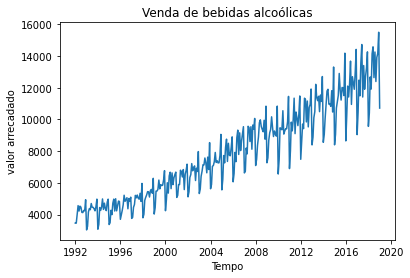

In [43]:
plt.plot(data)
plt.title('Venda de bebidas alcoólicas')
plt.ylabel('valor arrecadado')
plt.xlabel('Tempo')

# Decomposição da Série temporal

<Figure size 432x288 with 0 Axes>

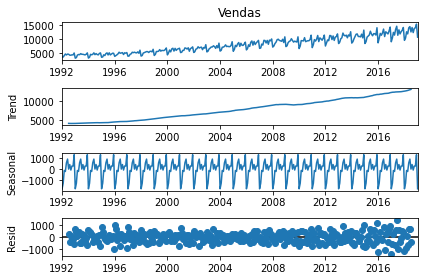

In [44]:
st= data['Vendas']
decomposicao = seasonal_decompose(st, model='additive', period = 12)
fig = plt.figure()
fig = decomposicao.plot()

A decomposição da série temporal mostra:<br>
->Tendência de aumento das vendas ao longo dos anos;<br>
-> As vendas apresentam sazonalidade;

# Teste de estacionariedade

In [45]:
def adf_test(serietemporal):
    adft = adfuller(serietemporal, autolag='AIC')
    adf = pd.Series(adft[0:4], index = ['Test Statistic', 'p-value', '# Lags Used', 'Number of Observations Used'])
    if adf[1]<=0.05:
        print(adf)
        print('H0 rejeitada: Os dados são estacionários')
    else:
        print(adf)
        print('H0 não rejeitada: Os dados não são estacionários')

adf_test(data)

Test Statistic                   2.037405
p-value                          0.998720
# Lags Used                     14.000000
Number of Observations Used    310.000000
dtype: float64
H0 não rejeitada: Os dados não são estacionários


In [46]:
# Diferenciação
data['#Vendas'] = data['Vendas'] - data['Vendas'].shift(1)
data_sten = data['#Vendas'].dropna()
adf_test(data_sten)

Test Statistic                  -4.365960
p-value                          0.000341
# Lags Used                     13.000000
Number of Observations Used    310.000000
dtype: float64
H0 rejeitada: Os dados são estacionários


O parâmetro de diferanciação deverá ser diferente de zero

# ARIMA

O ARIMA será feito por meio do auto_arima

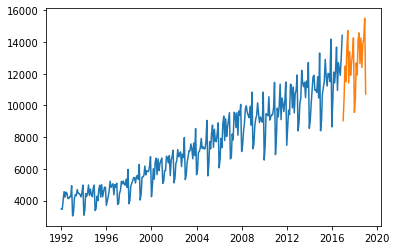

In [9]:
train, test = train_test_split(st, train_size=300)
plt.plot(train)
plt.plot(test)

In [10]:
model = auto_arima(st, seasonal=True, m=12)

In [11]:
result_AR = model.fit(train)

In [12]:
result_AR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  300
Model:             SARIMAX(3, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -2022.610
Date:                            Mon, 20 Jun 2022   AIC                           4065.220
Time:                                    14:02:43   BIC                           4101.814
Sample:                                         0   HQIC                          4079.886
                                            - 300                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2069      0.191     -1.081      0.280      -0.582       0.168
ar.L2          0.1231      0.083      1.492      0.136      -0.039       0.285
ar.L3          0.3543      0.070      5.078      0.000       0.218       0.491
ma.L1         -0.6637      0.198     -3.351      0.001      -1.052      -0.276
ma.L2         -0.2199      0.156     -1.408      0.159      -0.526       0.086
ar.S.L12       0.8599      0.068     12.693      0.000       0.727       0.993
ar.S.L24      -0.8231      0.055    -14.887      0.000      -0.931      -0.715
ma.S.L12      -1.1401      0.093    -12.256      0.000      -1.322      -0.958
ma.S.L24       0.6593      0.090      7.352      0.000       0.484       0.835
sigma2      6.851e+04   5161.274     13.274      0.000    5.84e+04    7.86e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                15.04
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               4.41   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
prediction, confint = result_AR.predict(n_periods=25, return_conf_int=True)

In [48]:
cf= pd.DataFrame(confint)

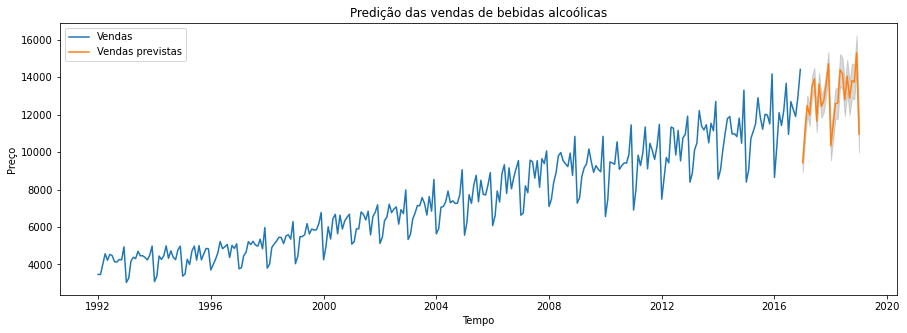

In [49]:
prediction_series = pd.Series(prediction,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train, label = 'Vendas')
ax.plot(prediction_series, label='Vendas previstas' )
plt.title('Predição das vendas de bebidas alcoólicas')
plt.xlabel('Tempo')
plt.ylabel('Preço')
ax.legend(loc=0)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)


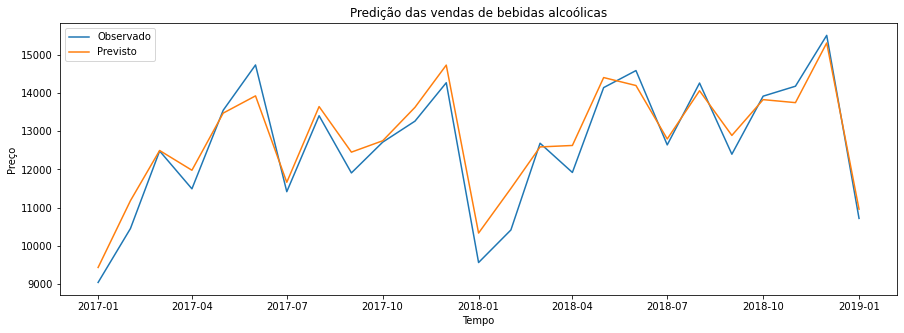

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(test, label='Observado')
ax.plot(prediction_series, label='Previsto')
plt.title('Predição das vendas de bebidas alcoólicas')
plt.xlabel('Tempo')
plt.ylabel('Preço')
ax.legend()

In [17]:
mse = mean_squared_error(test, prediction_series)
print('MSE: '+str(mse))
mae = mean_absolute_error(test, prediction_series)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test, prediction_series))
print('RMSE: '+str(rmse))

MSE: 217397.22109541873
MAE: 380.30022804984793
RMSE: 466.2587490819006


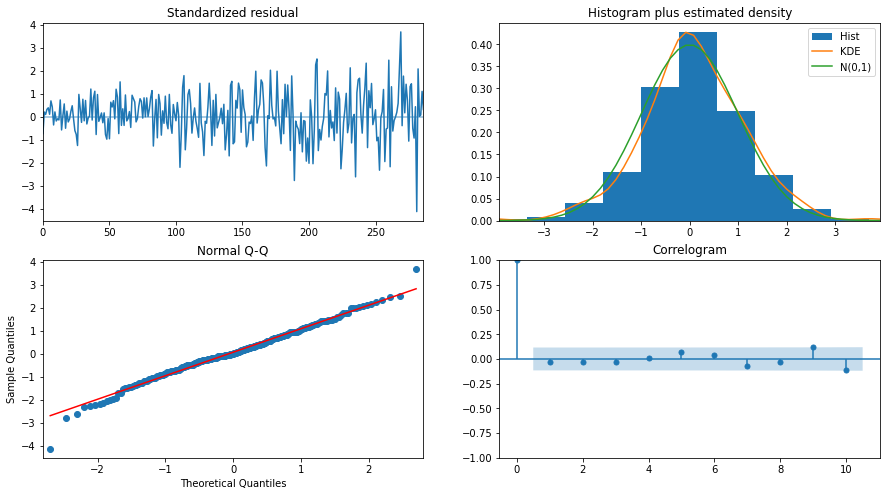

In [18]:
result_AR.plot_diagnostics(figsize=(15,8))
plt.show()

Canto superior esquerdo: Os erros residuais parecem flutuar em torno de uma média de zero no início da série;<br>

Superior Direita: O gráfico de densidade sugere distribuição normal com média zero;<br>

Inferior esquerdo: Todos os pontos apresentam distribuição normal, pois ficam perfeitamente alinhados com a linha vermelha;<br>

Inferior direito: O gráfico Correlograma, também conhecido como gráfico ACF, mostra que os erros residuais não são autocorrelacionados. Qualquer autocorrelação implicaria que existe algum padrão nos erros residuais que não são explicados no modelo. 

# Forecast

In [63]:
n_periods = 25
index_prediction = pd.date_range(data.index[-1], periods = n_periods, freq='M')

In [64]:
fc_series = pd.Series(prediction, index=index_prediction)
lower_series = pd.Series(confint[:, 0], index=index_prediction)
upper_series = pd.Series(confint[:, 1], index=index_prediction)

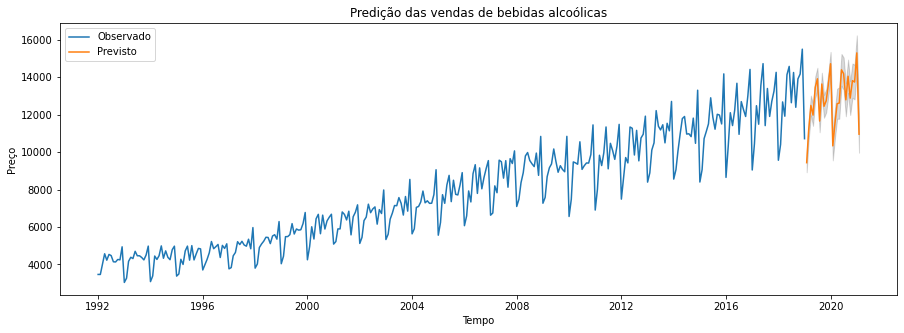

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(st, label='Observado')
ax.plot(fc_series, label='Previsto')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.title('Predição das vendas de bebidas alcoólicas')
plt.xlabel('Tempo')
plt.ylabel('Preço')
ax.legend()

A previsão realizada pelo modelo conseguiu captar o comportamento sazonal das vendas.